In [1]:
# Bandits

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import gymnasium as gym
# import gym
# import gym_bandits
import numpy as np
from scipy.special import softmax as softmax_fn
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle

import sys
import random
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline

In [3]:
sns.set_theme()
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

# Baseline strategies

In [4]:
Q = np.array([7, 3])
np.argmax(Q)

np.int64(0)

In [5]:
def pure_exploitation(env, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int32)
    
    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    name = 'Pure exploitation'
    es = tqdm(range(n_episodes), desc='Episodes for: ' + name, leave=False)
    for e in es:
        action = np.argmax(Q)
        # print(action)
        # print("env.step(action)")
        # print(env.step(action))
        
        next_state, reward, done, truncated, info = env.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]            
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [6]:
def pure_exploration(env, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int32)
    
    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    name = 'Pure exploration'
    es = tqdm(range(n_episodes), desc='Episodes for: ' + name, leave=False)
    for e in es:
        action = np.random.randint(len(Q))
        next_state, reward, done, truncated, info = env.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]            
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

# Simple strategies

In [7]:
def epsilon_greedy(env, epsilon=0.1, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int32)
    
    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    name = 'Pure exploration'
    es = tqdm(range(n_episodes), desc='Episodes for: ' + name, leave=False)
    for e in es:
        if np.random.random() <= epsilon:
            action = np.random.randint(len(Q))
        else:
            action = np.argmax(len(Q))
        
        next_state, reward, done, truncated, info = env.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]            
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [8]:
np.random.uniform(low=2, high=100, size=(2, 2)), np.random.random((2, 2))
max(0.2, .5)
np.maximum(0.2, .5)

np.float64(0.5)

In [9]:
init_epsilon = 1.0
min_epsilon = 0.01
decay_ratio = 0.5 
n_episodes = 10

def lin_decay(init_epsilon, min_epsilon, decay_ratio, n_episodes):
    decay_range = init_epsilon - min_epsilon
    decay_episodes = int(n_episodes * decay_ratio)
    decay = decay_range / decay_episodes
    return init_epsilon, decay

epsilon, decay = lin_decay(init_epsilon, min_epsilon, decay_ratio, n_episodes)
for e in range(n_episodes):
    print(epsilon)
    epsilon = max(epsilon - decay, min_epsilon)

1.0
0.802
0.6040000000000001
0.4060000000000001
0.20800000000000007
0.010000000000000064
0.01
0.01
0.01
0.01


In [10]:
def lin_dec_epsilon_greedy(
    env, init_epsilon=1.0, min_epsilon=0.01, decay_ratio=0.05, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int32)
    
    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    epsilon, decay = lin_decay(init_epsilon, min_epsilon, decay_ratio, n_episodes)
    name = f"Lin Epsilon-Greedy {init_epsilon}, {min_epsilon}, {decay_ratio}"
    es = tqdm(
        range(n_episodes), 
        desc='Episodes for: ' + name, 
        leave=False
    )
    
    for e in es:
        if np.random.random() <= epsilon:
            action = np.random.randint(len(Q))
        else:
            action = np.argmax(len(Q))
        epsilon = max(epsilon - decay, min_epsilon)
        
        next_state, reward, done, truncated, info = env.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]            
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [11]:
init_epsilon = 1.0
min_epsilon = 0.01
decay_ratio = 0.1
n_episodes = 10

def exp_decay(init_epsilon, min_epsilon, decay_ratio, n_episodes):
    decay_episodes = int(n_episodes * decay_ratio)
    min_epsilon = max(min_epsilon, 1e-45)
    decay = np.exp(-np.log(init_epsilon / min_epsilon) / decay_episodes)
    return init_epsilon, decay


decay, epsilon = exp_decay(init_epsilon, min_epsilon, decay_ratio, n_episodes)
for e in range(n_episodes):
    print(f"{epsilon:f}")
    epsilon = max(epsilon * decay, min_epsilon)

0.010000
0.010000
0.010000
0.010000
0.010000
0.010000
0.010000
0.010000
0.010000
0.010000


In [12]:
def exp_dec_epsilon_greedy(
    env, init_epsilon=1.0, min_epsilon=0.01, decay_ratio=0.05, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int32)
    
    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    name = f"Exp Epsilon-Greedy {init_epsilon}, {min_epsilon}, {decay_ratio}"
    es = tqdm(
        range(n_episodes), 
        desc='Episodes for: ' + name, 
        leave=False
    )
    
    epsilon, decay = exp_decay(init_epsilon, min_epsilon, decay_ratio, n_episodes)
    for e in es:
        if np.random.random() <= epsilon:
            action = np.random.randint(len(Q))
        else:
            action = np.argmax(len(Q))
        epsilon = max(epsilon * decay, min_epsilon)
        
        next_state, reward, done, truncated, info = env.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]            
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [13]:
np.full((2), 1.0)
np.full((2), 100)

array([100, 100])

In [14]:
def optimistic_initialization(
    env, optimistic_estimate=1.0, initial_count=100, n_episodes=1000):
    
    Q = np.full((env.action_space.n), optimistic_estimate, dtype=np.float64)
    N = np.full((env.action_space.n), initial_count, dtype=np.int32)
    
    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    name = f"Optimistic {optimistic_estimate}, {initial_count}"
    es = tqdm(
        range(n_episodes),
        desc='Episodes for: ' + name, 
        leave=False
    )
    
    for e in es:
        action = np.argmax(Q)
        next_state, reward, done, truncated, info = env.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

# Two-Armed Bandit environments

In [15]:
import buffalo_gym

SEEDS = (12, 34, 56, 78, 90)

In [16]:
b2_Vs = []
for seed in SEEDS:
    env_name = 'Bandit-v0'
    env = gym.make(env_name, seed=seed)
    env.reset()
    
    print(env.action_space.n)
    print('Two-Armed Bandit environment with seed', seed)

10
Two-Armed Bandit environment with seed 12
10
Two-Armed Bandit environment with seed 34
10
Two-Armed Bandit environment with seed 56
10
Two-Armed Bandit environment with seed 78
10
Two-Armed Bandit environment with seed 90


In [17]:
b2_Vs = []
for seed in SEEDS:
    env_name = 'Bandit-v0'
    env = gym.make(env_name, seed=seed)
    env.reset()

    # For the new gymnasium API, we need to access the true Q-values differently
    # We'll use a simple approach to estimate the true Q-values by sampling
    # This is a workaround since we don't have direct access to internal environment parameters
    
    # Sample each action multiple times to estimate Q-values
    n_samples = 1000
    rewards = np.zeros((env.action_space.n, n_samples))
    
    for action in range(env.action_space.n):
        for i in range(n_samples):
            env.reset()
            _, reward, _, _, _ = env.step(action)
            rewards[action, i] = reward
    
    # Estimate true Q-values as the mean reward for each action
    true_Q = np.mean(rewards, axis=1)
    opt_V = np.max(true_Q)
    
    print(f"Best Bandit: {np.argmax(true_Q)}")
    # Store the estimated optimal value
    b2_Vs.append(opt_V)
    
    print('Two-Armed Bandit environment with seed', seed)
    print('Estimated Q-values:', true_Q)
    print('V*:', b2_Vs[-1])
    print()

Best Bandit: 3
Two-Armed Bandit environment with seed 12
Estimated Q-values: [3.21980288 3.0948036  3.26000215 3.39904514 3.37167344 3.16813353
 3.19709565 3.3499591  3.0132748  3.39015114]
V*: 3.399045140494849

Best Bandit: 6
Two-Armed Bandit environment with seed 34
Estimated Q-values: [3.38999534 3.07750184 3.44643442 3.17776784 3.26972945 3.19234604
 3.47088527 3.28405251 3.23989273 3.2463492 ]
V*: 3.470885272989502

Best Bandit: 7
Two-Armed Bandit environment with seed 56
Estimated Q-values: [3.36558544 3.19553915 3.17884608 3.11929803 3.13215817 3.3270867
 3.17244616 3.39435844 3.29778315 3.27033215]
V*: 3.3943584358916863

Best Bandit: 9
Two-Armed Bandit environment with seed 78
Estimated Q-values: [3.20201002 3.20227131 3.20355235 3.31884276 3.15307611 3.20825952
 3.20434969 3.22495597 3.22097706 3.3207067 ]
V*: 3.320706703817242

Best Bandit: 0
Two-Armed Bandit environment with seed 90
Estimated Q-values: [3.48125908 3.35494061 3.27508886 3.24798438 3.22489074 3.41337827
 3.2

# Running simple strategies on Two-Armed Bandit environments

In [ ]:
def b2_run_simple_strategies_experiment(env_name='Bandit-v0'):
    results = {}
    experiments = [
        # baseline strategies
        lambda env: pure_exploitation(env),
        lambda env: pure_exploration(env),
        
        # epsilon greedy
        lambda env: epsilon_greedy(env, epsilon=0.07),
        lambda env: epsilon_greedy(env, epsilon=0.1),
        
        # epsilon greedy linearly decaying
        lambda env: lin_dec_epsilon_greedy(
            env, init_epsilon=1.0, min_epsilon=0.0, decay_ratio=0.1
        ),
        lambda env: lin_dec_epsilon_greedy(
            env, init_epsilon=0.3, min_epsilon=0.001, decay_ratio=0.1
        ),
        
        # epsilon greedy exponentially decaying
        lambda env: exp_dec_epsilon_greedy(
            env, init_epsilon=1.0, min_epsilon=0.0, decay_ratio=0.1
        ),
        lambda env: exp_dec_epsilon_greedy(
            env, init_epsilon=0.3, min_epsilon=0.0, decay_ratio=0.3
        ),
        
        # epsilon greedy
        lambda env: optimistic_initialization(
            env, optimistic_estimate=1.0, initial_count=10
        ),
        lambda env: optimistic_initialization(
            env, optimistic_estimate=1.0, initial_count=50
        ),
    ]
    
    
    # For the new gymnasium API, we need to access the true Q-values differently
    # We'll use a simple approach to estimate the true Q-values by sampling
    # This is a workaround since we don't have direct access to p_dist and r_dist
    
    # Sample each action multiple times to estimate Q-values
    n_samples = 1000
    rewards = np.zeros((env.action_space.n, n_samples))
    
    for action in range(env.action_space.n):
        for i in range(n_samples):
            env.reset()
            _, reward, _, _, _ = env.step(action)
            rewards[action, i] = reward
    
    for env_seed in tqdm(SEEDS, desc='All experiments'):
        env = gym.make(env_name, seed=env_seed)
        env.reset()
        
        # Estimate true Q-values as the mean reward for each action
        true_Q = np.mean(rewards, axis=1)
        opt_V = np.max(true_Q)
        
        for seed in tqdm(SEEDS, desc='All environments', leave=False):
            for experiment in tqdm(
                experiments, desc=f'Experiments with seed {seed}', leave=False):
                env.reset()
                env.action_space.seed(seed)
                np.random.seed(seed)
                random.seed(seed)
                name, Re, Qe, Ae = experiment(env)
                Ae = np.expand_dims(Ae, -1)
                
                episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
                
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, Ae.shape), Ae, axis=1).squeeze()
                regret = opt_V - Q_selected
                cum_regret = np.cumsum(regret)
                
                if name not in results.keys(): results[name] = {}
                if 'Re' not in results[name].keys(): results[name]['Re'] = []
                if 'Qe' not in results[name].keys(): results[name]['Qe'] = []
                if 'Ae' not in results[name].keys(): results[name]['Ae'] = []
                if 'cum_regret' not in results[name].keys(): 
                    results[name]['cum_regret'] = []
                if 'episode_mean_rew' not in results[name].keys(): 
                    results[name]['episode_mean_rew'] = []

                results[name]['Re'].append(Re)
                results[name]['Qe'].append(Qe)
                results[name]['Ae'].append(Ae)
                results[name]['cum_regret'].append(cum_regret)
                results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results

b2_results_s = b2_run_simple_strategies_experiment()

All experiments:   0%|          | 0/5 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 34:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 56:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 78:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

Experiments with seed 90:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Lin Epsilon-Greedy 0.3, 0.001, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 1.0, 0.0, 0.1:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Episodes for: Optimistic 1.0, 50:   0%|          | 0/1000 [00:00<?, ?it/s]

# Plotting results of simple strategies on Two-Armed Bandit environments

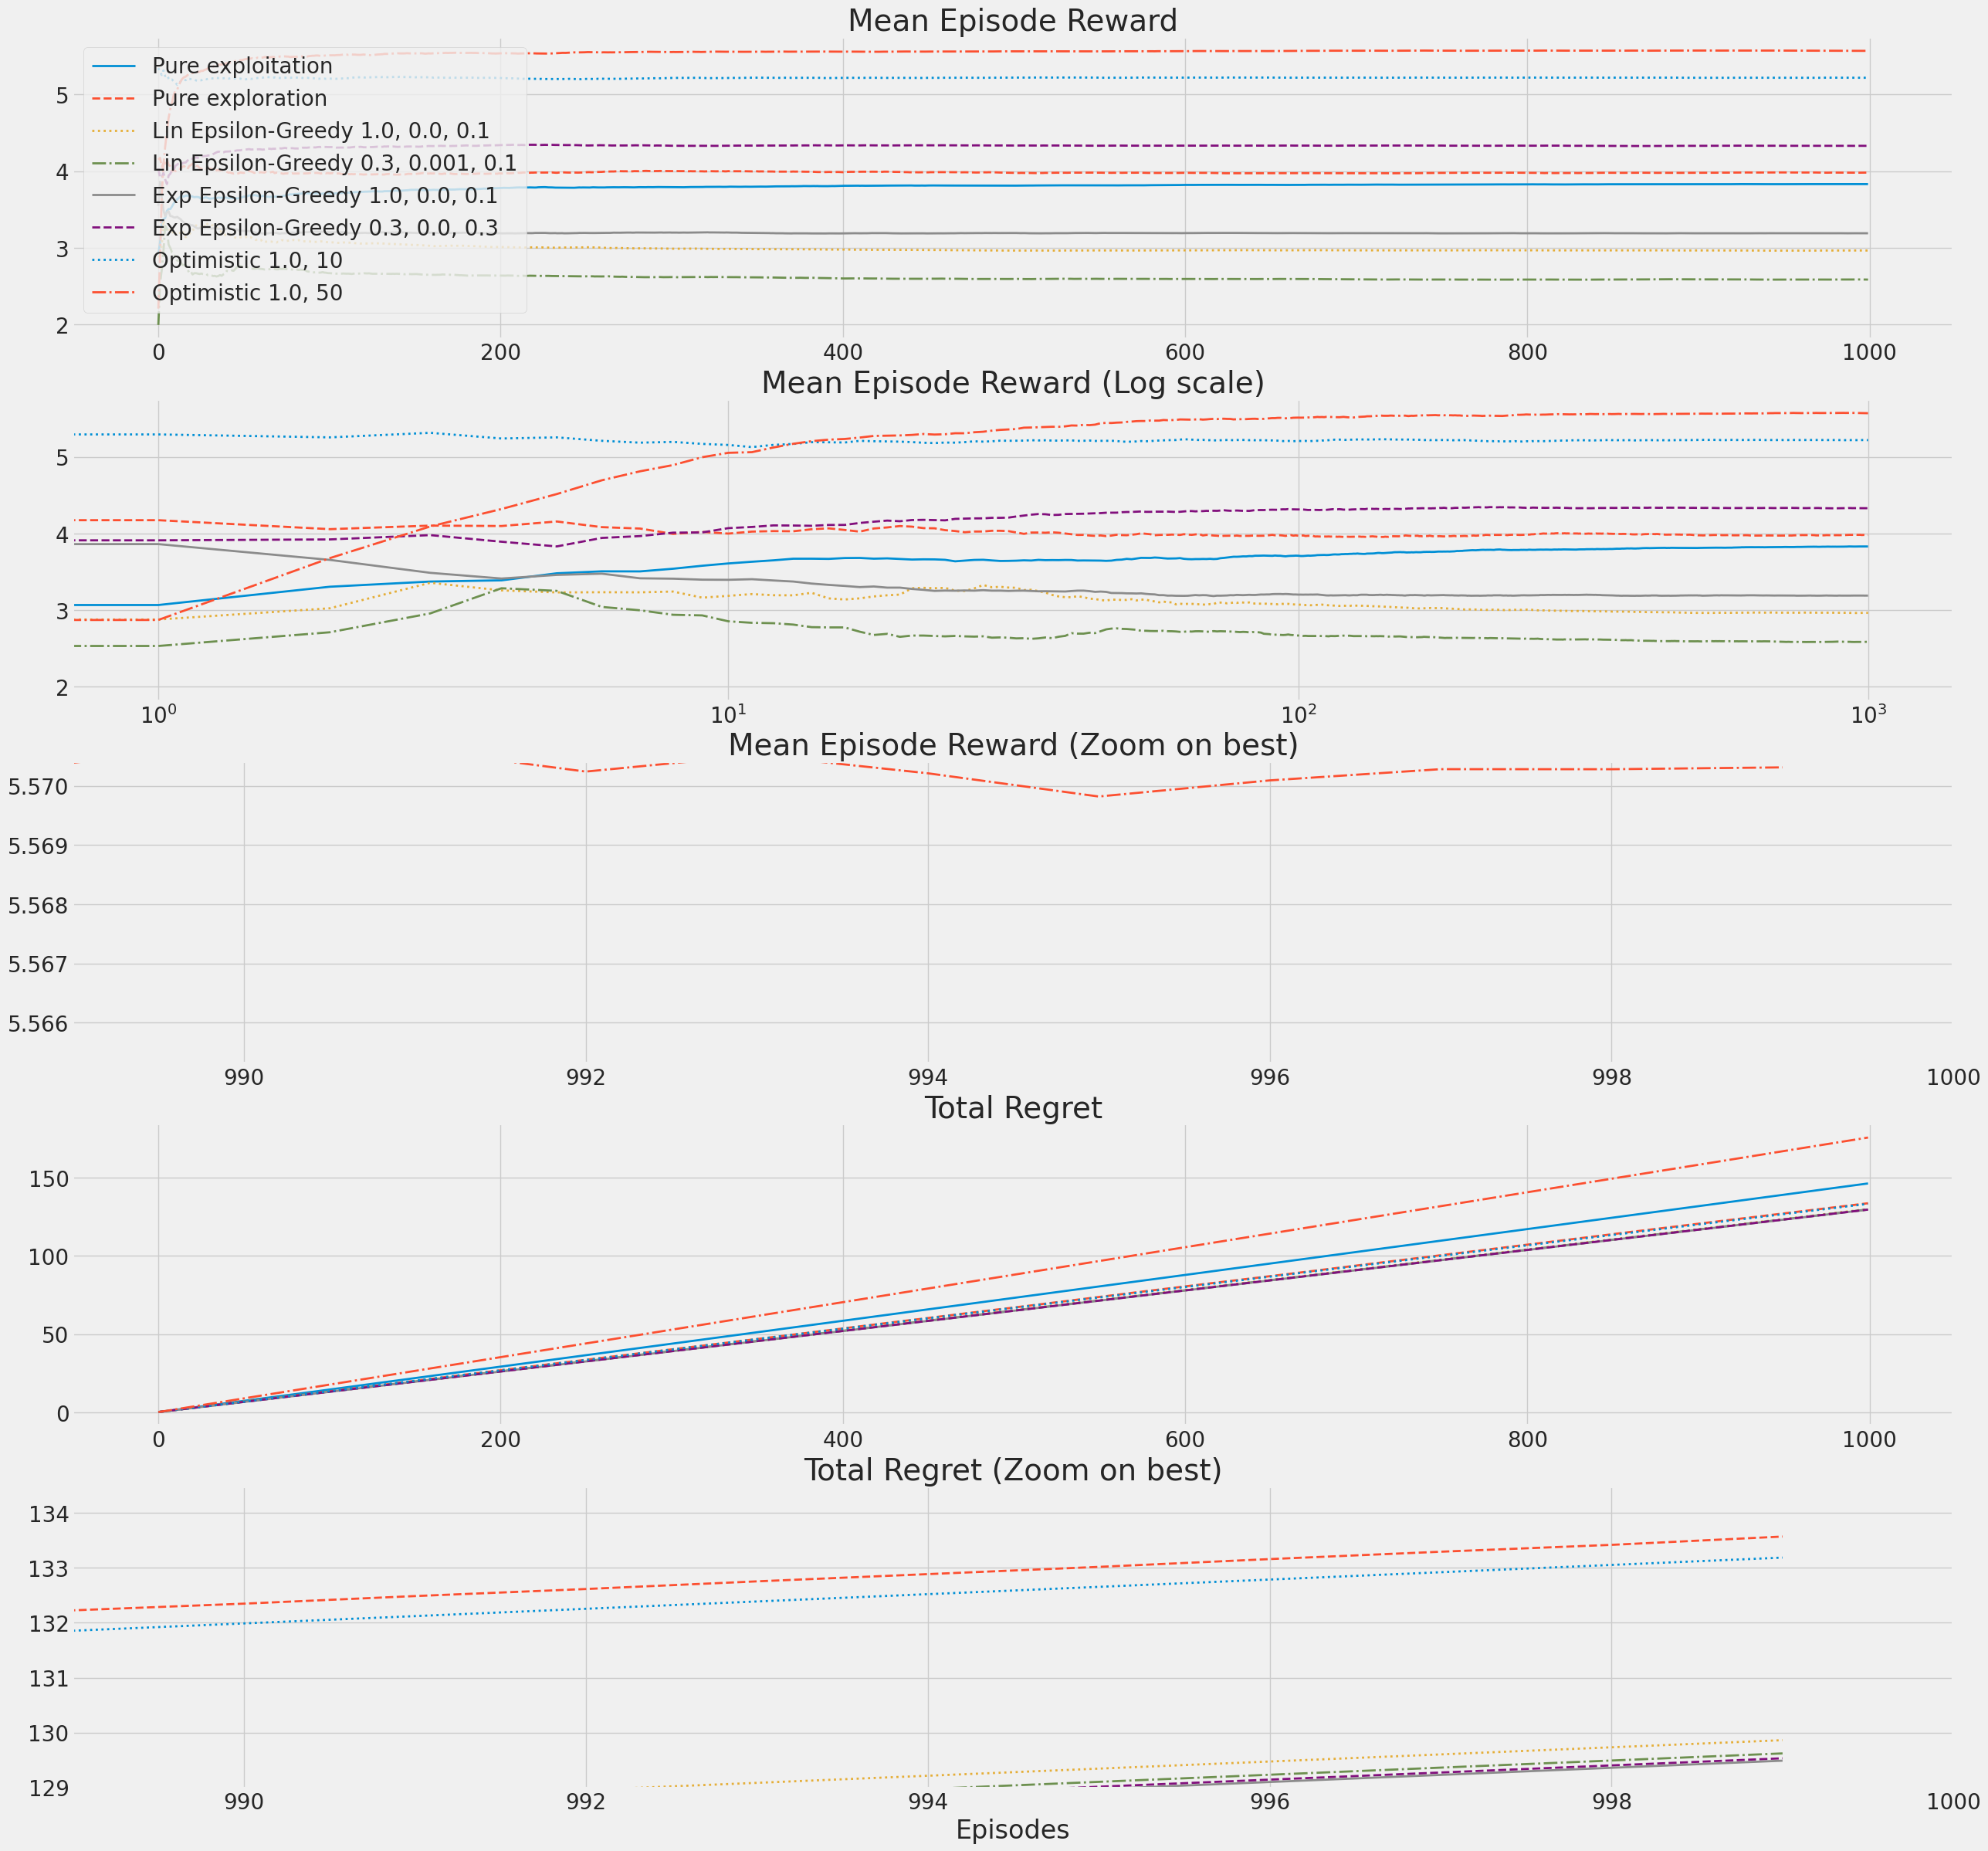

In [19]:
fig, axs = plt.subplots(5, 1, figsize=(28, 28), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b2_results_s.items():
    color = next(linecycler)

    # reward
    episode_mean_rew = np.array(result['episode_mean_rew'])
    mean_episode_mean_rew = np.mean(episode_mean_rew, axis=0)

    axs[0].plot(mean_episode_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_episode_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_episode_mean_rew[-1]: max_ret = mean_episode_mean_rew[-1]
    axs[2].axis((
        mean_episode_mean_rew.shape[0]*0.989,
        mean_episode_mean_rew.shape[0],
        max_ret-0.005,
        max_ret+0.0001
        )
    )
    
    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)
    
    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((
            mean_cum_regret.shape[0]*0.989,
            mean_cum_regret.shape[0],
            min_reg-0.5,
            min_reg+5
        )
    )
    
    # config plot
    axs[0].set_title('Mean Episode Reward')
    axs[1].set_title('Mean Episode Reward (Log scale)')
    axs[2].set_title('Mean Episode Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Episodes')
    axs[0].legend(loc='upper left')

plt.show()

# Advanced strategies

In [20]:
np.nextafter(np.float32(0), np.float32(1))
1e-45
np.nextafter(2, 4)
d = np.zeros((10))
np.exp(10), 2.718281828459045**10

(np.float64(22026.465794806718), 22026.465794806703)

In [33]:
def softmax(
    env, init_temp=float('inf'), min_temp=0.0, decay_ratio=0.04, n_episodes=1000):
    
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int32)
    
    Qe = np.empty((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    actions = np.empty(n_episodes, dtype=np.int32)
    
    # can't really use infinity
    init_temp = min(init_temp, sys.float_info.max)
    
    # can't really use zero
    min_temp = max(min_temp, 1e-45)
    
    name = f'Lin SoftMax {init_temp}, {min_temp}, {decay_ratio}'
    es = tqdm(range(n_episodes), desc='Episodes for: ' + name, leave=False)
    
    epsilon, temp = lin_decay(init_temp, min_temp, decay_ratio, n_episodes)
    
    for e in es:
        scaled_Q = Q / temp
        norm_Q = scaled_Q - np.max(scaled_Q)
        exp_Q = np.exp(norm_Q)
        probs = exp_Q / np.sum(exp_Q)
        assert np.isclose(probs.sum(), 1.0)
        
        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]
        
        _, reward, _, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    return name, returns, Qe, actions

In [22]:
np.log(e), e
10**0.44
N = np.zeros((10), dtype=np.int16)
N

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int16)

In [35]:
def upper_confidence_bound(env: gym.Env, c=2, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int32)
    
    Qe = np.zeros((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.zeros((n_episodes), dtype=np.float64)
    actions = np.zeros((n_episodes), dtype=np.int32)
    
    name = f'UCB {c}'
    es = tqdm(range(n_episodes), desc=f'Episodes for: {name}', leave=False)
    
    for e in es:
        action = e
        if e >= env.action_space.n:
            U = c * np.sqrt(np.log(e) / N)
            action = np.argmax(Q + U)
        
        _, reward, _, _, _ = env.step(action)
        Q[action] += (reward - Q[action]) / N[action]
        N[action] += 1
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = action
    
    return name, returns, Qe, action

In [28]:
Q = np.zeros((10), dtype=np.float64)
samples = np.random.normal(loc=Q, scale=1 / (np.sqrt(N) + 0.01 ))

samples
# np.mean(samples)

array([ -13.20966269, -182.45634411,   41.49332992,  121.63714771,
       -112.36592914,  182.3739568 ,  -70.23460732,  100.89522194,
        -55.05488877,  142.83769221])

In [25]:
def thompson_sampling(env: gym.Env, alpha=1, beta=0, n_episodes=1000):
    Q = np.zeros((env.action_space.n), dtype=np.float64)
    N = np.zeros((env.action_space.n), dtype=np.int32)
    
    Qe = np.zeros((n_episodes, env.action_space.n), dtype=np.float64)
    returns = np.zeros((n_episodes), dtype=np.float64)
    actions = np.zeros((n_episodes), dtype=np.int32)
    
    name = f"Thompson Sampling {alpha}, {beta}"
    es = tqdm(range(n_episodes), desc=f"Episodes for: {name}", leave=False)
    for e in es:
        samples = np.random.normal(loc=Q, scale=alpha / (np.sqrt(N) + beta))
        action = np.argmax(samples)
        
        _, reward, _, _, _ = env.step(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        
        Qe[e] = Q
        returns[e] = reward
        actions[e] = actions
    return name, returns, Qe, actions

# Running advanced strategies on Two-Armed Bandit environments

In [ ]:
def b2_run_advanced_strategies_experiment(env_name='Bandit-v0'):
    results = {}
    experiments = [
        # baseline strategies 
        lambda env: pure_exploitation(env),
        lambda env: pure_exploration(env),

        # best from simple strategies
        lambda env: optimistic_initialization(
            env, optimistic_estimate=1.0, initial_count=10),
        lambda env: exp_dec_epsilon_greedy(
            env, init_epsilon=0.3, min_epsilon=0.0, decay_ratio=0.3),

        # softmax
        lambda env: softmax(
            env, init_temp=float('inf'), min_temp=0.0, decay_ratio=0.005),
        lambda env: softmax(env, init_temp=100, min_temp=0.01, decay_ratio=0.01),

        # ucb
        lambda env: upper_confidence_bound(env, c=0.2),
        lambda env: upper_confidence_bound(env, c=0.5),

        # thompson sampling
        lambda env: thompson_sampling(env, alpha=1, beta=1),
        lambda env: thompson_sampling(env, alpha=0.5, beta=0.5),
    ]
    
        
    
    for env_seed in tqdm(SEEDS, desc='All experiments'):
        env = gym.make(env_name, seed=env_seed) ; env.reset()

        # For the new gymnasium API, we need to access the true Q-values differently
        # We'll use a simple approach to estimate the true Q-values by sampling
        # This is a workaround since we don't have direct access to p_dist and r_dist
        
        # Sample each action multiple times to estimate Q-values
        n_samples = 1000
        rewards = np.zeros((env.action_space.n, n_samples))
        
        for action in range(env.action_space.n):
            for i in range(n_samples):
                env.reset()
                _, reward, _, _, _ = env.step(action)
                rewards[action, i] = reward

        # Estimate true Q-values as the mean reward for each action
        true_Q = np.mean(rewards, axis=1)
        opt_V = np.max(true_Q)
        
        for seed in tqdm(SEEDS, desc='All environments', leave=False):
            for experiment in tqdm(
                experiments, 
                desc='Experiments with seed {}'.format(seed), 
                leave=False):
                np.random.seed(seed) ; random.seed(seed)
                name, Re, Qe, Ae = experiment(env)
                Ae = np.expand_dims(Ae, -1)
                episode_mean_rew = np.cumsum(Re) / (np.arange(len(Re)) + 1)
                
                Q_selected = np.take_along_axis(
                    np.tile(true_Q, Ae.shape), Ae, axis=1
                ).squeeze() 
                
                regret = opt_V - Q_selected
                cum_regret = np.cumsum(regret)
                
                if name not in results.keys(): results[name] = {}
                if 'Re' not in results[name].keys(): results[name]['Re'] = []
                if 'Qe' not in results[name].keys(): results[name]['Qe'] = []
                if 'Ae' not in results[name].keys(): results[name]['Ae'] = []
                if 'cum_regret' not in results[name].keys(): 
                    results[name]['cum_regret'] = []
                if 'episode_mean_rew' not in results[name].keys(): 
                    results[name]['episode_mean_rew'] = []
                
                results[name]['Re'].append(Re)
                results[name]['Qe'].append(Qe)
                results[name]['Ae'].append(Ae)
                results[name]['cum_regret'].append(cum_regret)
                results[name]['episode_mean_rew'].append(episode_mean_rew)
    return results

b2_results_a = b2_run_advanced_strategies_experiment()

All experiments:   0%|          | 0/5 [00:00<?, ?it/s]

All environments:   0%|          | 0/5 [00:00<?, ?it/s]

Experiments with seed 12:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes for: Pure exploitation:   0%|          | 0/1000 [00:00<?, ?it/s]

[3.16504005 3.33406892 3.29398034 3.40706897 3.18043762 3.17397194
 3.0708369  3.22905955 3.1491671  3.44983105]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [

Episodes for: Pure exploration:   0%|          | 0/1000 [00:00<?, ?it/s]

[3.16504005 3.33406892 3.29398034 3.40706897 3.18043762 3.17397194
 3.0708369  3.22905955 3.1491671  3.44983105]
[[6]
 [1]
 [2]
 [3]
 [3]
 [0]
 [6]
 [1]
 [4]
 [5]
 [9]
 [2]
 [6]
 [0]
 [5]
 [8]
 [2]
 [9]
 [3]
 [4]
 [3]
 [1]
 [7]
 [0]
 [2]
 [6]
 [2]
 [0]
 [4]
 [6]
 [9]
 [0]
 [0]
 [9]
 [8]
 [9]
 [6]
 [1]
 [8]
 [4]
 [0]
 [4]
 [1]
 [5]
 [5]
 [3]
 [4]
 [5]
 [5]
 [0]
 [6]
 [6]
 [3]
 [2]
 [4]
 [3]
 [9]
 [6]
 [7]
 [4]
 [1]
 [4]
 [9]
 [5]
 [3]
 [5]
 [0]
 [2]
 [9]
 [6]
 [4]
 [7]
 [6]
 [2]
 [3]
 [2]
 [6]
 [4]
 [5]
 [0]
 [0]
 [5]
 [4]
 [0]
 [3]
 [7]
 [9]
 [6]
 [8]
 [6]
 [1]
 [4]
 [9]
 [6]
 [5]
 [9]
 [2]
 [4]
 [0]
 [8]
 [4]
 [4]
 [3]
 [7]
 [3]
 [6]
 [1]
 [4]
 [3]
 [8]
 [8]
 [6]
 [9]
 [8]
 [4]
 [9]
 [4]
 [1]
 [4]
 [1]
 [4]
 [3]
 [2]
 [8]
 [0]
 [1]
 [4]
 [6]
 [5]
 [4]
 [2]
 [0]
 [1]
 [2]
 [5]
 [2]
 [0]
 [1]
 [4]
 [7]
 [7]
 [9]
 [1]
 [6]
 [1]
 [3]
 [0]
 [1]
 [8]
 [4]
 [8]
 [8]
 [8]
 [8]
 [3]
 [9]
 [5]
 [1]
 [6]
 [3]
 [2]
 [3]
 [1]
 [9]
 [3]
 [2]
 [2]
 [8]
 [9]
 [3]
 [5]
 [9]
 [1]
 [7]
 [4]
 [0]
 [8]
 [

Episodes for: Optimistic 1.0, 10:   0%|          | 0/1000 [00:00<?, ?it/s]

[3.16504005 3.33406892 3.29398034 3.40706897 3.18043762 3.17397194
 3.0708369  3.22905955 3.1491671  3.44983105]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [

Episodes for: Exp Epsilon-Greedy 0.3, 0.0, 0.3:   0%|          | 0/1000 [00:00<?, ?it/s]

[3.16504005 3.33406892 3.29398034 3.40706897 3.18043762 3.17397194
 3.0708369  3.22905955 3.1491671  3.44983105]
[[6]
 [0]
 [3]
 [6]
 [5]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [

Episodes for: Lin SoftMax 1.7976931348623157e+308, 1e-45, 0.005:   0%|          | 0/1000 [00:00<?, ?it/s]

[3.16504005 3.33406892 3.29398034 3.40706897 3.18043762 3.17397194
 3.0708369  3.22905955 3.1491671  3.44983105]
[[1]
 [7]
 [2]
 [5]
 [0]
 [9]
 [9]
 [0]
 [9]
 [1]
 [2]
 [6]
 [9]
 [8]
 [0]
 [5]
 [5]
 [4]
 [7]
 [1]
 [7]
 [0]
 [1]
 [1]
 [3]
 [6]
 [4]
 [8]
 [2]
 [7]
 [7]
 [3]
 [3]
 [9]
 [6]
 [9]
 [7]
 [8]
 [4]
 [4]
 [4]
 [9]
 [1]
 [9]
 [4]
 [4]
 [4]
 [3]
 [4]
 [0]
 [0]
 [7]
 [6]
 [0]
 [3]
 [2]
 [0]
 [5]
 [4]
 [0]
 [5]
 [8]
 [1]
 [2]
 [6]
 [4]
 [5]
 [4]
 [8]
 [6]
 [6]
 [4]
 [4]
 [8]
 [2]
 [9]
 [0]
 [5]
 [0]
 [6]
 [6]
 [8]
 [9]
 [4]
 [6]
 [9]
 [6]
 [3]
 [3]
 [2]
 [9]
 [4]
 [9]
 [8]
 [6]
 [0]
 [9]
 [9]
 [0]
 [6]
 [3]
 [5]
 [6]
 [5]
 [3]
 [0]
 [8]
 [9]
 [1]
 [2]
 [3]
 [4]
 [8]
 [2]
 [4]
 [6]
 [5]
 [3]
 [7]
 [1]
 [1]
 [4]
 [7]
 [2]
 [1]
 [9]
 [1]
 [6]
 [2]
 [6]
 [6]
 [0]
 [3]
 [3]
 [1]
 [0]
 [0]
 [5]
 [0]
 [3]
 [9]
 [8]
 [9]
 [1]
 [3]
 [2]
 [4]
 [5]
 [4]
 [7]
 [6]
 [6]
 [1]
 [7]
 [6]
 [2]
 [3]
 [9]
 [3]
 [3]
 [6]
 [6]
 [0]
 [5]
 [7]
 [9]
 [7]
 [1]
 [2]
 [4]
 [6]
 [0]
 [3]
 [3]
 [9]
 [9]
 [7]
 [

Episodes for: Lin SoftMax 100, 0.01, 0.01:   0%|          | 0/1000 [00:00<?, ?it/s]

[3.16504005 3.33406892 3.29398034 3.40706897 3.18043762 3.17397194
 3.0708369  3.22905955 3.1491671  3.44983105]
[[1]
 [7]
 [2]
 [5]
 [0]
 [9]
 [9]
 [0]
 [9]
 [0]
 [2]
 [6]
 [9]
 [8]
 [0]
 [5]
 [5]
 [4]
 [7]
 [1]
 [7]
 [0]
 [1]
 [0]
 [2]
 [6]
 [4]
 [8]
 [2]
 [7]
 [7]
 [3]
 [3]
 [9]
 [5]
 [9]
 [7]
 [8]
 [3]
 [3]
 [3]
 [9]
 [1]
 [9]
 [3]
 [3]
 [3]
 [3]
 [3]
 [0]
 [0]
 [7]
 [5]
 [0]
 [3]
 [2]
 [0]
 [4]
 [3]
 [0]
 [4]
 [7]
 [1]
 [2]
 [5]
 [4]
 [4]
 [3]
 [8]
 [5]
 [5]
 [3]
 [4]
 [8]
 [2]
 [9]
 [0]
 [5]
 [0]
 [6]
 [5]
 [8]
 [9]
 [3]
 [6]
 [9]
 [5]
 [3]
 [3]
 [3]
 [9]
 [3]
 [9]
 [8]
 [6]
 [0]
 [8]
 [9]
 [0]
 [5]
 [3]
 [5]
 [5]
 [5]
 [3]
 [0]
 [7]
 [8]
 [1]
 [2]
 [3]
 [3]
 [8]
 [2]
 [3]
 [6]
 [4]
 [3]
 [7]
 [1]
 [1]
 [3]
 [7]
 [2]
 [1]
 [9]
 [1]
 [5]
 [3]
 [5]
 [6]
 [0]
 [3]
 [3]
 [1]
 [0]
 [0]
 [5]
 [0]
 [3]
 [9]
 [8]
 [8]
 [1]
 [3]
 [2]
 [4]
 [4]
 [3]
 [7]
 [5]
 [6]
 [1]
 [7]
 [5]
 [3]
 [3]
 [9]
 [3]
 [3]
 [5]
 [5]
 [0]
 [4]
 [7]
 [9]
 [6]
 [1]
 [2]
 [3]
 [5]
 [0]
 [3]
 [3]
 [9]
 [9]
 [7]
 [

Episodes for: UCB 0.2:   0%|          | 0/1000 [00:00<?, ?it/s]

[3.16504005 3.33406892 3.29398034 3.40706897 3.18043762 3.17397194
 3.0708369  3.22905955 3.1491671  3.44983105]
[0]
(1,)


AxisError: axis 1 is out of bounds for array of dimension 1

# Plotting results of advanced strategies on Two-Armed Bandit  environments

# 10-Armed Gaussian Bandit environments

# Running simple strategies on 10-Armed Bandit environments

# Plotting results of simple strategies on 10-Armed Bandit environments

# Running advanced strategies on 10-Armed Bandit environments

# Plotting results of advanced strategies on 10-Armed Bandit environments